### Project by Samuel Nnamani a.k.a SammystTheAnalyst

#### Background of dataset
* The Heart dataset contains 10000 records of patients heart condition across 21 features. These features are categorized into three(3) aspects:
1. Vitals & Lab Tests: Blood Pressure, Cholesterol Level, BMI, Triglyceride Level, Fasting Blood Sugar, CRP Level, Homocysteine Level.
2. Lifestyle & Habits: Smoking, Exercise Habits, Alcohol Consumption, Sleep Hours, Sugar Consumption, Stress Level.
3. Medical History: Diabetes, Family Heart Disease, High Blood Pressure, High LDL, Low HDL.

#### Problems to be solved using the dataset
1. Correlation and Feature Interaction.
2. Risk Factor Analysis
3. Heart Disease Trend Analysis by Demographics.
4. Patients Clustering into Risk Groups.
5. Build a Patient Heart Scoring System.
6. Lifestyle vs Health Insights Dashboard.
7. Real-time Multi-Disease Prediction.

### Data Cleaning

In [1]:
# Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

In [2]:
# Read the dataset
df = pd.read_csv("heart_disease.csv")
print(df.head())

    Age  Gender  Blood Pressure  Cholesterol Level Exercise Habits Smoking  \
0  56.0    Male           153.0              155.0            High     Yes   
1  69.0  Female           146.0              286.0            High      No   
2  46.0    Male           126.0              216.0             Low      No   
3  32.0  Female           122.0              293.0            High     Yes   
4  60.0    Male           166.0              242.0             Low     Yes   

  Family Heart Disease Diabetes        BMI High Blood Pressure  ...  \
0                  Yes       No  24.991591                 Yes  ...   
1                  Yes      Yes  25.221799                  No  ...   
2                   No       No  29.855447                  No  ...   
3                  Yes       No  24.130477                 Yes  ...   
4                  Yes      Yes  20.486289                 Yes  ...   

  High LDL Cholesterol Alcohol Consumption Stress Level Sleep Hours  \
0                   No           

In [3]:
# Check for missing values
missing_values = df.isnull().sum()

# Check the datatypes
data_types = df.dtypes

# Check unique values for each column to identify categorical variables
unique_values = df.nunique()

missing_values, data_types, unique_values

(Age                       29
 Gender                    19
 Blood Pressure            19
 Cholesterol Level         30
 Exercise Habits           25
 Smoking                   25
 Family Heart Disease      21
 Diabetes                  30
 BMI                       22
 High Blood Pressure       26
 Low HDL Cholesterol       25
 High LDL Cholesterol      26
 Alcohol Consumption     2586
 Stress Level              22
 Sleep Hours               25
 Sugar Consumption         30
 Triglyceride Level        26
 Fasting Blood Sugar       22
 CRP Level                 26
 Homocysteine Level        20
 Heart Disease Status       0
 dtype: int64,
 Age                     float64
 Gender                   object
 Blood Pressure          float64
 Cholesterol Level       float64
 Exercise Habits          object
 Smoking                  object
 Family Heart Disease     object
 Diabetes                 object
 BMI                     float64
 High Blood Pressure      object
 Low HDL Cholesterol     

##### From the above code, we see that many columns have few missing values except for Alcohol Consumption, and also the target column "Heart Disease Status" does not have missing values. That is a great news. We see also, that the datatypes in the data cuts across only two datatypes(Objects and Float). I will need to do encoding later on the categorical columns

In [4]:
# Handling the missing values

# Fill missing numeric values with mean
numeric_cols = df.select_dtypes(include='float').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include="object").columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [5]:
# Encoding

# Binary Categorical columns (Yes/No or Male/Female)
binary_cols = [
    "Gender", "Smoking", "Family Heart Disease", "Diabetes", "High Blood Pressure", "Low HDL Cholesterol",
    "High LDL Cholesterol", "Heart Disease Status"
]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode multi-class columns
multi_class_cols = ["Exercise Habits", "Alcohol Consumption", "Stress Level", "Sugar Consumption"]
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# Show cleaned dataset info
df_cleaned_info = df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         10000 non-null  float64
 1   Gender                      10000 non-null  int32  
 2   Blood Pressure              10000 non-null  float64
 3   Cholesterol Level           10000 non-null  float64
 4   Smoking                     10000 non-null  int32  
 5   Family Heart Disease        10000 non-null  int32  
 6   Diabetes                    10000 non-null  int32  
 7   BMI                         10000 non-null  float64
 8   High Blood Pressure         10000 non-null  int32  
 9   Low HDL Cholesterol         10000 non-null  int32  
 10  High LDL Cholesterol        10000 non-null  int32  
 11  Sleep Hours                 10000 non-null  float64
 12  Triglyceride Level          10000 non-null  float64
 13  Fasting Blood Sugar         1000

,Age,Gender,Blood Pressure,Cholesterol Level,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,...,Homocysteine Level,Heart Disease Status,Exercise Habits_Low,Exercise Habits_Medium,Alcohol Consumption_Low,Alcohol Consumption_Medium,Stress Level_Low,Stress Level_Medium,Sugar Consumption_Low,Sugar Consumption_Medium
0,56.0,1,153.0,155.0,1,1,0,24.991591,1,1,...,12.387250,0,False,False,False,False,False,True,False,True
1,69.0,0,146.0,286.0,0,1,1,25.221799,0,1,...,19.298875,0,False,False,False,True,False,False,False,True
2,46.0,1,126.0,216.0,0,0,0,29.855447,0,1,...,11.230926,0,True,False,True,False,True,False,True,False
3,32.0,0,122.0,293.0,1,1,0,24.130477,1,0,...,5.961958,0,False,False,True,False,False,False,False,False
4,60.0,1,166.0,242.0,1,1,1,20.486289,1,0,...,8.153887,0,True,False,True,False,False,False,False,False


### Explorative Data Analysis

C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\366898337.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(["No Disease", "Disease"])
C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\366898337.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(["No Disease", "Disease"])
C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\366898337.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(["No Disease", "Disease"])


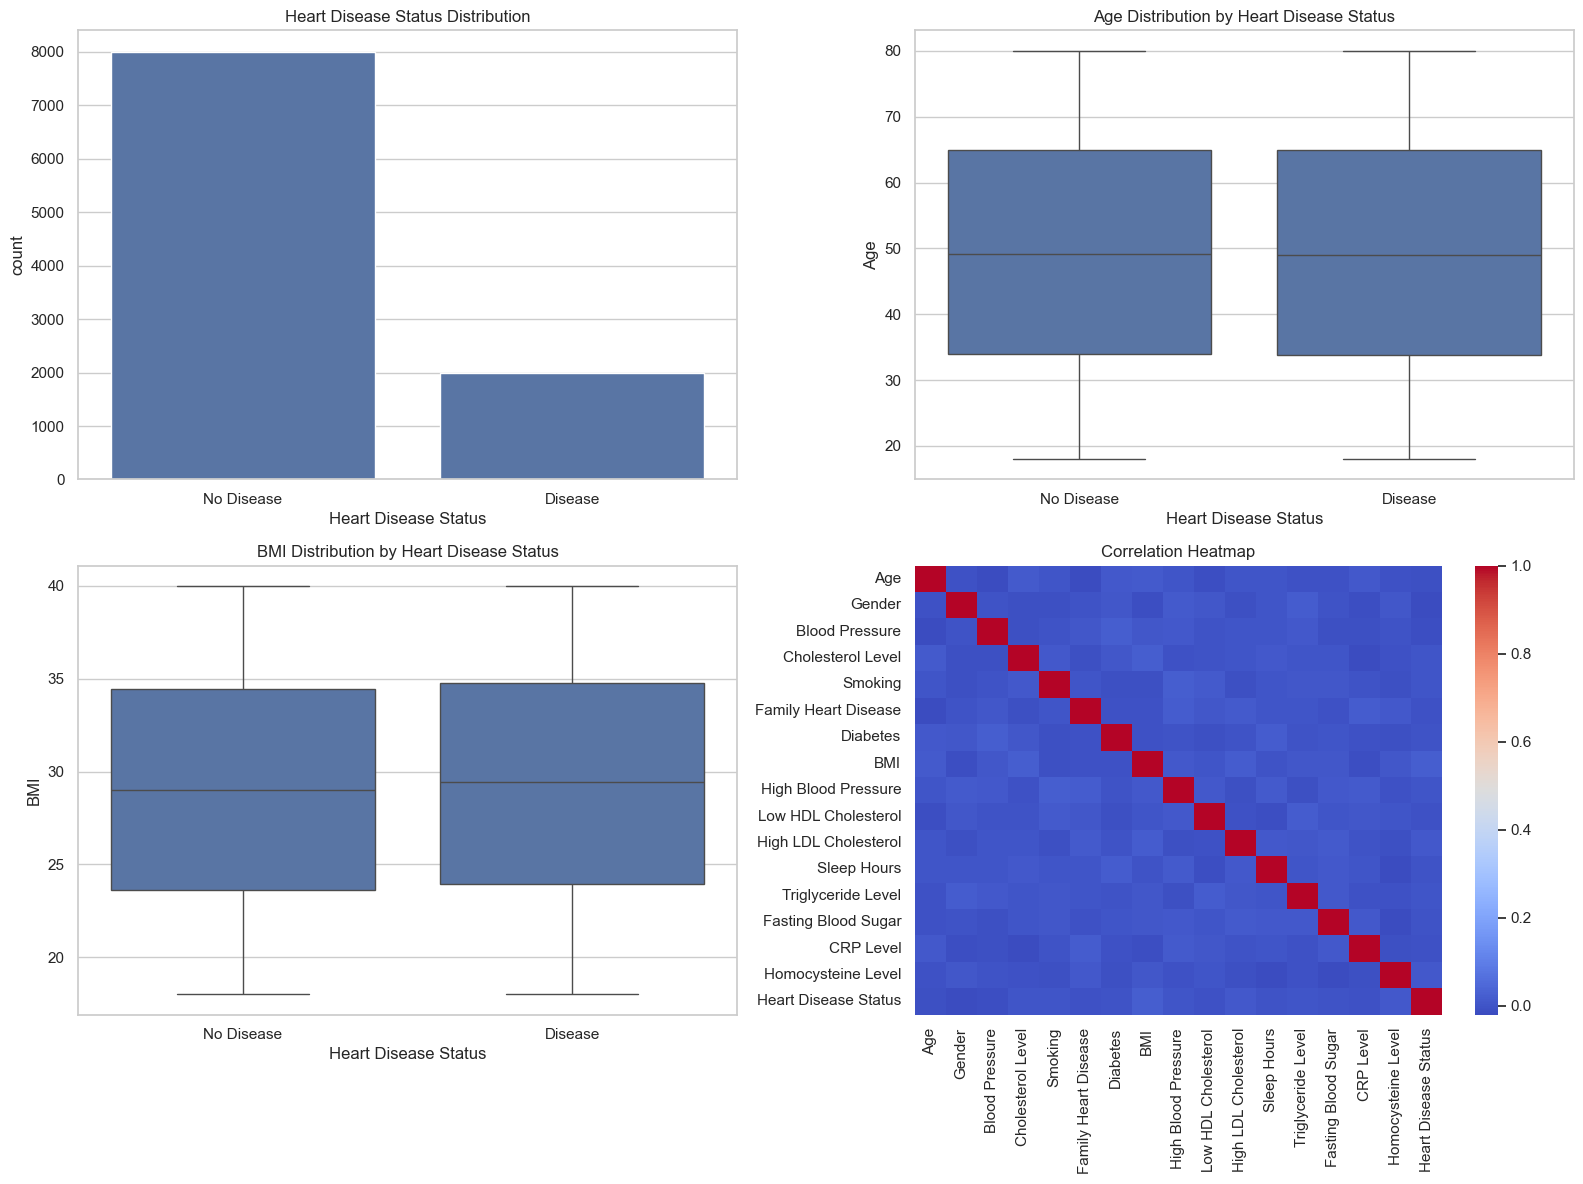

In [6]:
# Set plotting style
sns.set(style="whitegrid")

# Create a figure for multiple plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1.Countplot of Heart Disease Status
sns.countplot(data=df, x="Heart Disease Status", ax=axs[0,0])
axs[0,0].set_title("Heart Disease Status Distribution")
axs[0,0].set_xticklabels(["No Disease", "Disease"])

# 2.Boxplot of Age vs Heart Disease Status
sns.boxplot(data=df, x="Heart Disease Status", y="Age", ax=axs[0,1])
axs[0,1].set_title("Age Distribution by Heart Disease Status")
axs[0,1].set_xticklabels(["No Disease", "Disease"])

# 3.Boxplot of BMI vs Heart Disease Status
sns.boxplot(data=df, x="Heart Disease Status", y="BMI", ax=axs[1,0])
axs[1,0].set_title("BMI Distribution by Heart Disease Status")
axs[1,0].set_xticklabels(["No Disease", "Disease"])

# 4.Correlation Heatmap of Numeric Features
numeric_df = df.select_dtypes(include=["float64", "int32"])
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, ax=axs[1,1])
axs[1,1].set_title("Correlation Heatmap")

plt.tight_layout()

# Save the chart
plt.savefig("Distribution of Heart Disease Risk Metrics", dpi=300, bbox_inches="tight")
plt.show()

### I would need to save the cleaned data for the purpose of doing feature analysis for Diabetes

In [7]:
df.to_csv("cleaned_heart_data.csv", index=None)

### Heart Disease Trend Analysis by Demographics

Goal: I want to find patterns in heart disease rates by Age groups, Gender, Smoking status, Blood pressure status and Cholesterol levels

#### Heart Disease by Age group
Group Ages into bins and check prevalence.

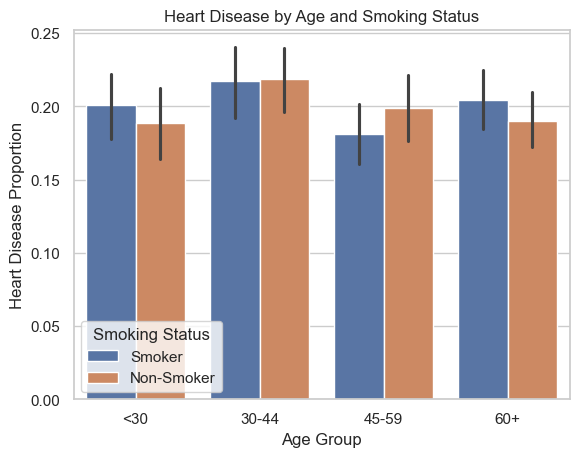

In [8]:
# Create Age bins
df["Age Group"] = pd.cut(df["Age"], bins=[0, 30, 45, 60, 100],
                         labels=["<30", "30-44", "45-59", "60+"])
df["Smoking Label"] = df["Smoking"].map({0: "Non-Smoker", 1:"Smoker"})
# Calculate prevalence
#age_group_summary = df.groupby("Age Group")["Heart Disease Status"].mean()

# Plot
sns.barplot(data=df, x="Age Group", y="Heart Disease Status", hue="Smoking Label")
plt.title("Heart Disease by Age and Smoking Status")
plt.xlabel("Age Group")
plt.ylabel("Heart Disease Proportion")
plt.legend(title="Smoking Status")
# Save the chart
plt.savefig("Heart Disease by Age and Smoking Status", dpi=300, bbox_inches="tight")
plt.show()

#### Heart Disease by Age Group and Diabetes

C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\471052027.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=df, kind="bar",


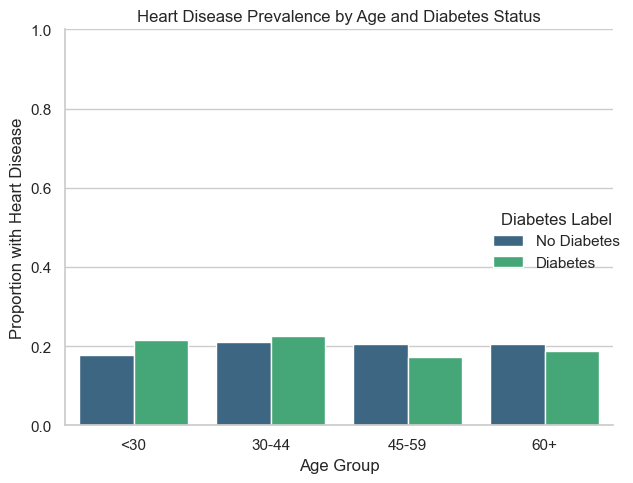

In [9]:
# Create Age bins
df["Age Group"] = pd.cut(df["Age"], 
                         bins=[0, 30, 45, 60, 100],
                         labels=["<30", "30-44", "45-59", "60+"])
# Map the Diabetes category
df["Diabetes Label"] = df["Diabetes"].map({0: "No Diabetes", 1:"Diabetes"})

sns.catplot(data=df, kind="bar",
            x="Age Group", y="Heart Disease Status",
            hue="Diabetes Label", ci=None, palette="viridis")

plt.title("Heart Disease Prevalence by Age and Diabetes Status")
plt.ylabel("Proportion with Heart Disease")
plt.xlabel("Age Group")
plt.ylim(0,1)
plt.tight_layout()
# Save the chart
plt.savefig("Heart Disease Prevalence by Age and Diabetes Status", dpi=300, bbox_inches="tight")
plt.show()

#### Heart Disease by Blood Pressure

C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\1227086553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hbp_summary.index, y=hbp_summary.values, palette="flare")


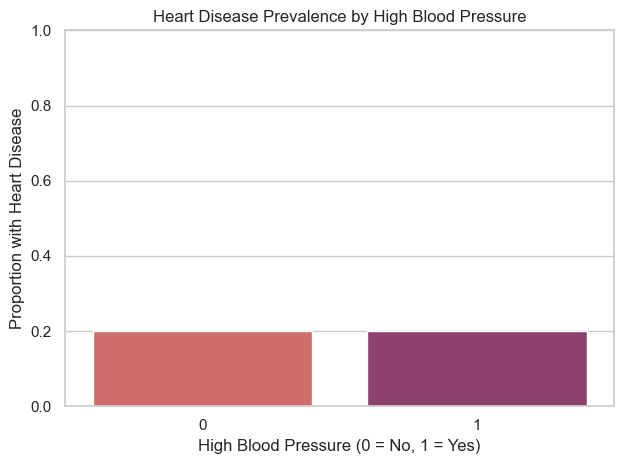

In [10]:
hbp_summary = df.groupby("High Blood Pressure")["Heart Disease Status"].mean()

sns.barplot(x=hbp_summary.index, y=hbp_summary.values, palette="flare")
plt.title("Heart Disease Prevalence by High Blood Pressure")
plt.ylabel("Proportion with Heart Disease")
plt.xlabel("High Blood Pressure (0 = No, 1 = Yes)")
plt.ylim(0,1)
plt.tight_layout()
# Save the chart
plt.savefig("Heart Disease Prevalence by High Blood Pressure", dpi=300, bbox_inches="tight")
plt.show()

#### Heart Disease by Gender

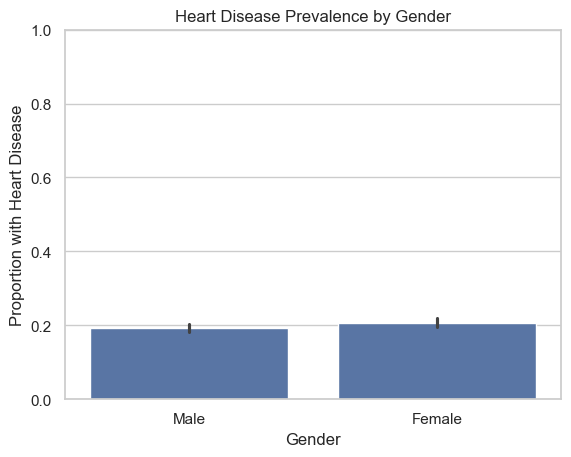

In [11]:
df["Gender Label"] = df["Gender"].map({0: "Female", 1:"Male"})

sns.barplot(data=df, x="Gender Label", y="Heart Disease Status")
plt.title("Heart Disease Prevalence by Gender")
plt.ylabel("Proportion with Heart Disease")
plt.xlabel("Gender")
plt.ylim(0,1)
# Save the chart
plt.savefig("Heart Disease Prevalence by Gender", dpi=300, bbox_inches="tight")
plt.show()

#### Heart Disease by Blood Pressure and Gender

C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\1478998563.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=df, kind="bar",


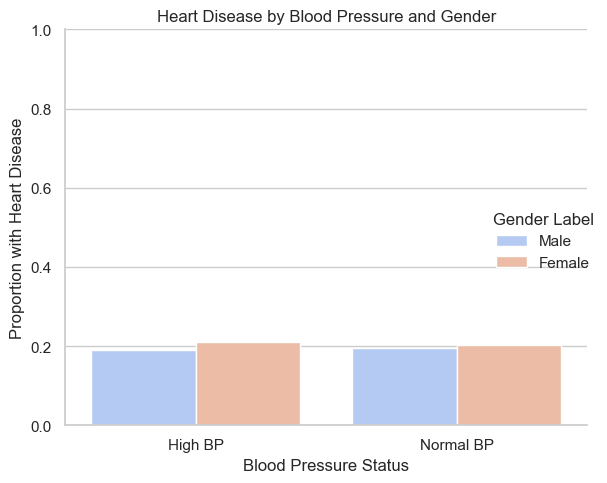

In [12]:
df["HBP Label"] = df["High Blood Pressure"].map({0: "Normal BP", 1: "High BP"})

sns.catplot(data=df, kind="bar",
            x="HBP Label", y ="Heart Disease Status",
            hue="Gender Label", ci=None, palette="coolwarm")

plt.title("Heart Disease by Blood Pressure and Gender")
plt.ylabel("Proportion with Heart Disease")
plt.xlabel("Blood Pressure Status")
plt.ylim(0,1)
plt.tight_layout()
# Save the chart
plt.savefig("Heart Disease Prevalence by Blood Pressure and Gender", dpi=300, bbox_inches="tight")
plt.show()

#### Heart Disease by Smoking Status

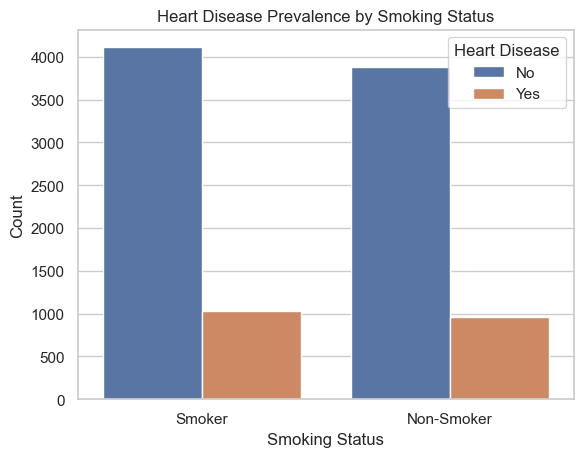

In [13]:
df["Smoking Label"] = df["Smoking"].map({0: "Non-Smoker", 1: "Smoker"})

# plt.figure(figsize=(5,4))
sns.countplot(data=df, x="Smoking Label", hue="Heart Disease Status")
plt.title("Heart Disease Prevalence by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.legend(title="Heart Disease", labels=["No", "Yes"])
# Save the chart
plt.savefig("Heart Disease Prevalence by Smoking Status", dpi=300, bbox_inches="tight")
plt.show()

### Feature Interaction and Correlation for Heart Disease

Goal: I aim to identify the features that most significantly influence heart disease status and the correlation between these numeric features.

#### 1. Tree-based Model Feature Analysis (RandomForestClassifier)

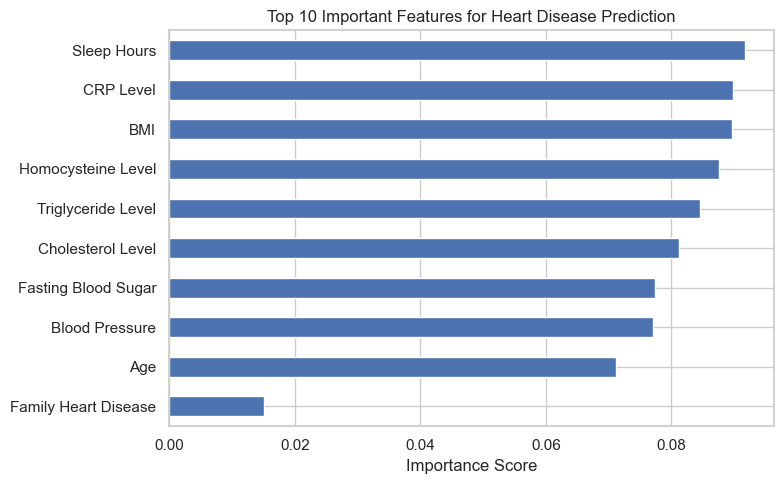

In [14]:
# Define features and target
X_heart = df.drop("Heart Disease Status", axis=1)
y_heart = df["Heart Disease Status"]

# Encode X using One-hot encoding
X_encoded = pd.get_dummies(X_heart, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_heart, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Plot the top 10 features' importance
feat_imp = pd.Series(rf.feature_importances_, index=X_encoded.columns)
top_features = feat_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top_features.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features for Heart Disease Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
# Save the chart
plt.savefig("Top 10 Important Features for Heart Disease Prediction", dpi=300, bbox_inches="tight")
plt.show()

#### From the above result, it is obvious that "Sleep Hours", "CRP Level", "BMI", "Homocysteine Level", "Triglyceride Level", "Cholesterol Level", "Fasting Blood Sugar", "Blood Pressure", "Age", "Family Heart Disease" contribute the most to Heart Disease Risk.

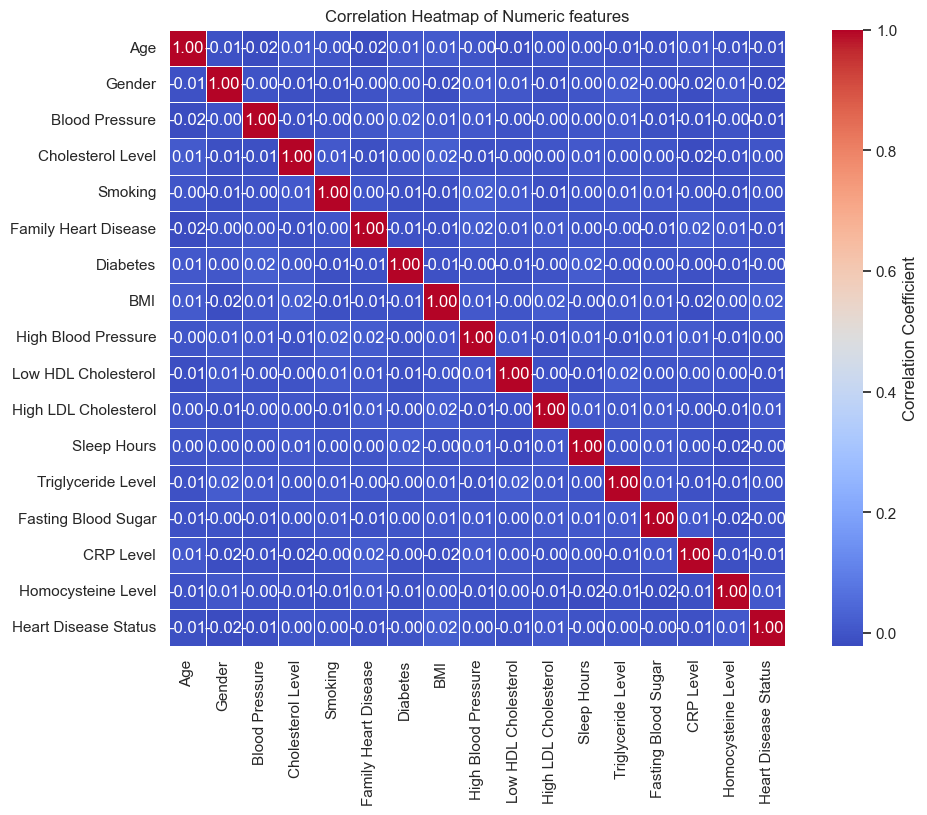

In [15]:
# Correlation
# Filter only numeric columns
numeric_df = df.select_dtypes(include=["int32", "float64"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidth=0.5, cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Heatmap of Numeric features")
# plt.tight_layout()
# Save the chart
plt.savefig("Correlation Heatmap of Numeric Features", dpi=300, bbox_inches="tight")
plt.show()

#### 2. Feature Analysis using Univariate Feature Selection

C:\Users\HOME\AppData\Local\Temp\ipykernel_8808\387430994.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Score", y="Feature", data=top_scores, palette="viridis")


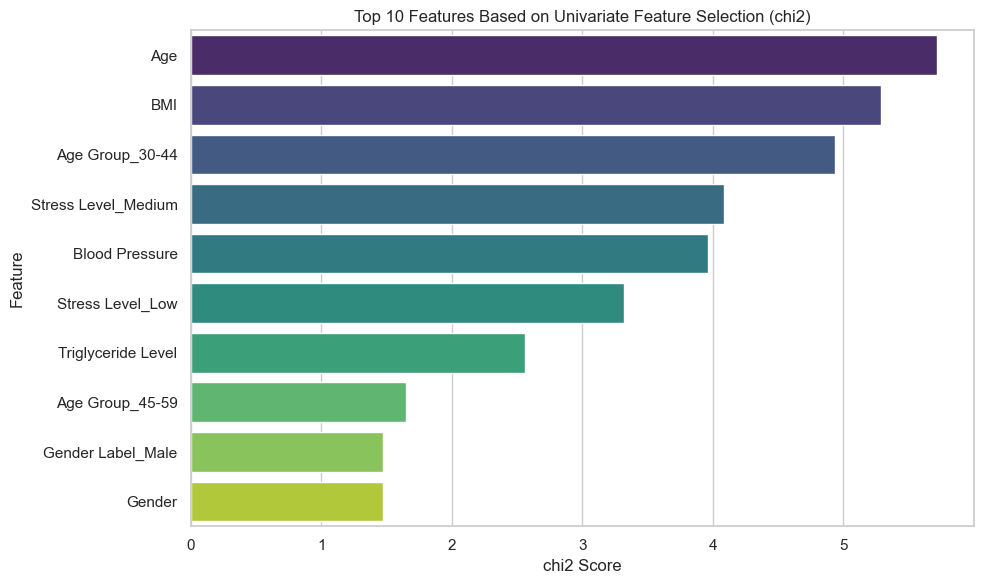

In [16]:
# Feature Analysis using Univariate Feature Selection
selector = SelectKBest(score_func=chi2, k=10)
x_new = selector.fit_transform(X_encoded, y_heart)

# Get feature scores
scores = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

# Get only the top 10
top_scores = scores.head(10)

# Plot the top 10 Features
plt.figure(figsize=(10,6))
sns.barplot(x="Score", y="Feature", data=top_scores, palette="viridis")
plt.title("Top 10 Features Based on Univariate Feature Selection (chi2)")
plt.xlabel("chi2 Score")
plt.ylabel("Feature")
plt.tight_layout()
# Save the chart
plt.savefig("Top 10 Features Based on Univariate Feature Selection (chi2)", dpi=300, bbox_inches="tight")
plt.show()

#### 3. Feature Analysis using Recursive Feature Elimination(RFE)

C:\Users\HOME\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HOME\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

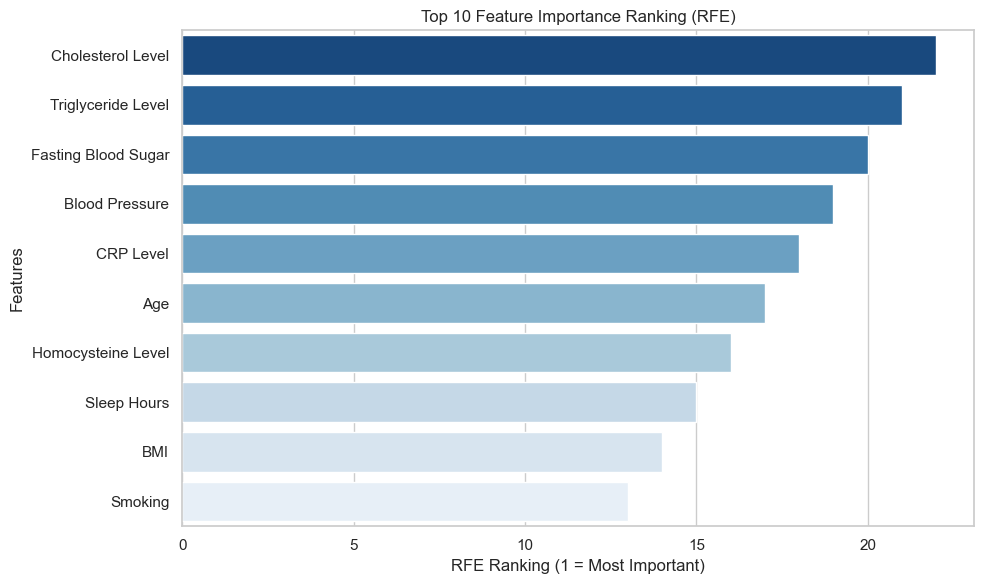

In [17]:
# Initialize model
logreg = LogisticRegression(max_iter=1000)

# Perform RFE(I set the n_features_to_select as 10)
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X_encoded, y_heart)

# Get feature rankings
ranking = rfe.ranking_
features = X_encoded.columns

# Create a DataFrame for visualization
rfe_df = pd.DataFrame({
    "Feature": features,
    "Ranking": ranking
}).sort_values("Ranking", ascending=False)

# Get the Top 10 features
top_rfe_df = rfe_df.head(10)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x="Ranking", y="Feature", data=top_rfe_df, palette="Blues_r")
plt.title("Top 10 Feature Importance Ranking (RFE)")
plt.xlabel("RFE Ranking (1 = Most Important)")
plt.ylabel("Features")
plt.tight_layout()
# Save the chart
plt.savefig("Top 10 Feature Importance Ranking (RFE)", dpi=300, bbox_inches="tight")
plt.show()

### Risk Factor Analysis

Goal: I want to quantify and interpret how various factors contribute to the likehood of heart disease.

In [18]:
# Using the Odds Ratio Analysis with Logistic Regression
# Assuming I already have X and y from preprocessing
X_const = sm.add_constant(X_heart)

# Convert the columns to a numeric datatype
X_const2 = X_const.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y_heart, errors="coerce")

# Convert the boolean columns to int
bool_cols = X_const2.select_dtypes(include="bool").columns
X_const2[bool_cols] = X_const2[bool_cols].astype(int)

In [19]:
# After coercing, it is fundamental that there will be some NaNs; thus, I need to clean by removing them.
# First, I will encode any column containing text
X_const3 = pd.get_dummies(X_const2, drop_first=True)

# Combine and drop rows only where y is missing
data = pd.concat([X_const3, y], axis=1)
data = data.dropna(subset=[y.name])        # Only drop rows where y is NaN

# Fill remaining NaNs in X with the mean
X_clean = data.drop(columns=y.name)

# Replace inf/-inf with NaN
X_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs with mean (or zero as fallback)
X_clean = X_clean.fillna(X_clean.mean(numeric_only=True)).fillna(0)

# Confirm cleanup
print("Any NaNs left in X_clean?", X_clean.isna().any().any())
print("Any infs in X_clean?", np.isinf(X_clean.to_numpy()).any())

Any NaNs left in X_clean? False
Any infs in X_clean? False


In [20]:
# Check for duplicate columns
# print(X_clean.T.duplicated())

# Drop the duplicate columns(Smoking Label, Diabetes Label, Gender Label, HBP Label)
X_clean = X_clean.drop(columns=["Smoking Label", "Diabetes Label", "Gender Label" ,"HBP Label"])

# Check for Constant Columns(No variability)
constant_cols = [col for col in X_clean.columns if X_clean[col].nunique() <= 1]
# print("Constant columns:\n", constant_cols)

# Drop them
X_clean.drop(columns=constant_cols, inplace=True)

Optimization terminated successfully.
         Current function value: 0.499640
         Iterations 5
                        Odds Ratio   2.5% CI   97.5 CI
Stress Level_Medium       1.076221  0.956147  1.211374
High LDL Cholesterol      1.030869  0.934622  1.137028
Exercise Habits_Medium    1.014649  0.901096  1.142512
BMI                       1.003860  0.996440  1.011335
Smoking                   1.003381  0.909802  1.106585
High Blood Pressure       1.003241  0.909584  1.106542
Homocysteine Level        1.000845  0.989833  1.011979
Triglyceride Level        0.999909  0.999356  1.000462
Cholesterol Level         0.999456  0.998405  1.000508
Fasting Blood Sugar       0.998544  0.996604  1.000487


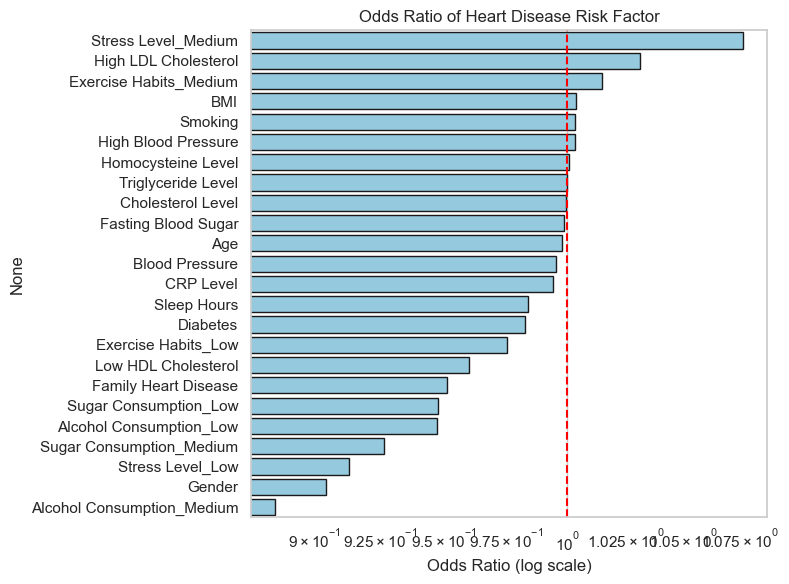

In [21]:
y_clean = data[y.name]

# Fit it into the model
model = sm.Logit(y_clean, X_clean)
result = model.fit()

# Get odds ratios and confidence intervals
odds_ratios = np.exp(result.params)
conf = np.exp(result.conf_int())
conf.columns = ["2.5%", "97.5%"]

# Combine into a readable DataFrame
odds_df = pd.DataFrame({
    "Odds Ratio": odds_ratios,
    "2.5% CI": conf["2.5%"],
    "97.5 CI": conf["97.5%"]
}).sort_values(by="Odds Ratio", ascending=False)

print(odds_df.head(10))

# Plot the graph
plt.figure(figsize=(8, 6))
sns.barplot(x="Odds Ratio", y=odds_df.index, data=odds_df, color='skyblue', edgecolor='k')
plt.axvline(x=1, color='red', linestyle='--')
plt.title("Odds Ratio of Heart Disease Risk Factor")
plt.xlabel("Odds Ratio (log scale)")
plt.xscale("log")
plt.tight_layout()
# Save the chart
plt.savefig("Odds Ratio (log scale)", dpi=300, bbox_inches="tight")
plt.show()

### Patients Clustering into Risk Groups (K-Means)
Goal: Using unsupervised learning, I want to segment the patients based on similar characteristics. It can be useful for targeted prevention or treatment strategies.

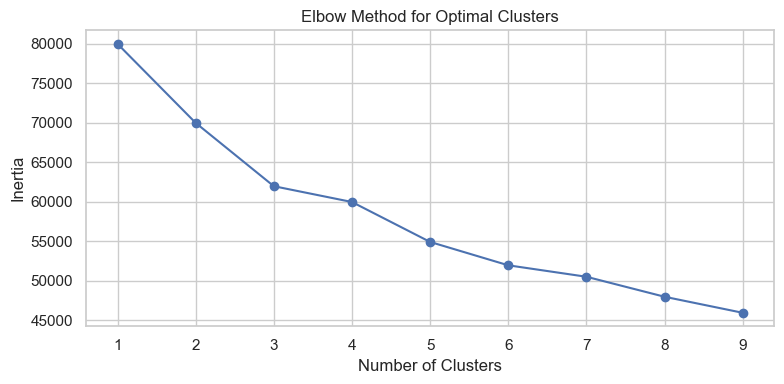

In [22]:
# STEP 1: Pick important numeric features that are most related to health risk
features = ["Age", "Blood Pressure", "Cholesterol Level", "High Blood Pressure", "Sleep Hours", 
            "Diabetes", "Smoking", "Heart Disease Status"]

X = df[features]

# STEP 2: Scale the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 3: Determing Optimal Number of Clusters (Elbow Method)
inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
# Save the chart
plt.savefig("Elbow Method for Optimal Clusters", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
# Applying K-Means Clustering. On that note, I want to assume optimal clusters = 3
kmeans = KMeans(n_clusters=3, random_state=42)
df["Risk Group"] = kmeans.fit_predict(X_scaled)

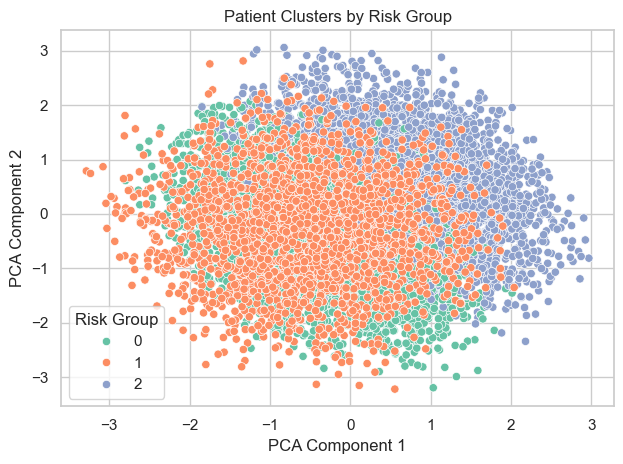

In [24]:
# Visualizing the clusters
# Use PCA to reduce dimensions for visualization

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Risk Group", palette="Set2")
plt.title("Patient Clusters by Risk Group")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Risk Group")
plt.tight_layout()
# Save the chart
plt.savefig("Patient Clusters by Risk Group", dpi=300, bbox_inches="tight")
plt.show()

### Building a Patient Heart Scoring system
Goal: I want to create a system that assigns each patient a risk score based on their health metrics. This score helps categorize them into Low, Medium or High risk groups.

In [25]:
# STEP 1: Identify Risk features

# I will try to use "Smoking", "High Blood Pressure", "Family Heart Disease", "Age", 
# "Triglyceride Level", "BMI", "Homocysteine Level", "Sleep Hours", "Cholesterol Level", "Stress Level_Medium" features

In [26]:
# STEP 2: Normalize the feature values

risk_features = ["Smoking", "High Blood Pressure", "Family Heart Disease", "Age", "Triglyceride Level", "BMI", "Homocysteine Level", "Sleep Hours", "Cholesterol Level", "Stress Level_Medium"]
scaler = MinMaxScaler()
X_clean_scaled = X_clean.copy()
X_clean_scaled = scaler.fit_transform(X_clean[risk_features])

In [27]:
# Step 3: Assign Weights to Features

weights = rf.feature_importances_             # This is the weights from RandomForestClassifier
weight = weights / np.sum(weights)            # This ensure weights sum to 1
weight

array([0.07114215, 0.00912983, 0.07705578, 0.0812122 , 0.0113117 ,
       0.01506486, 0.01048878, 0.0896005 , 0.01099756, 0.01420547,
       0.01377199, 0.09174693, 0.08453433, 0.07730631, 0.08973675,
       0.08765029, 0.0129754 , 0.01291018, 0.0107621 , 0.01323592,
       0.01124078, 0.01084125, 0.01310069, 0.01184135, 0.00942136,
       0.00858758, 0.00770325, 0.01175729, 0.01102423, 0.00957884,
       0.01006434])

In [28]:
# Create a DataFrame with the same column names
weight_df = pd.DataFrame(X_clean_scaled, columns=risk_features)

# Assign weights of the 10 most important features based on domain knowledge and data-driven insights to Features.

weights_dict = {
    "Smoking": 0.011312,
    "High Blood Pressure": 0.010998,
    "Family Heart Disease": 0.015065,
    "Age": 0.071142,
    "Triglyceride Level": 0.084534,
    "BMI": 0.089601,
    "Homocysteine Level": 0.087650,
    "Sleep Hours": 0.091747,
    "Cholesterol Level": 0.081212,
    "Stress Level_Medium": 0.011241
}

In [29]:
# STEP 4: Compute the Risk Score

weight_df["heart_risk_score"] = sum(
    weight_df[feature] * weight for feature, weight in weights_dict.items()
)

In [30]:
# STEP 5: Categorize Scores into Risk Levels

weight_df["heart_risk_group"] = pd.qcut(
    weight_df["heart_risk_score"], q=3, labels=["Low", "Medium", "High"]
)

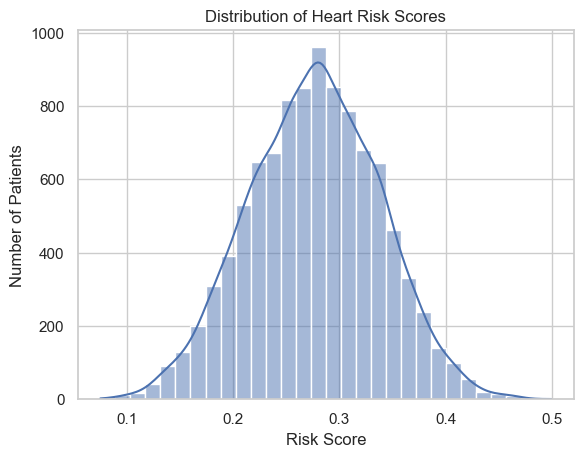

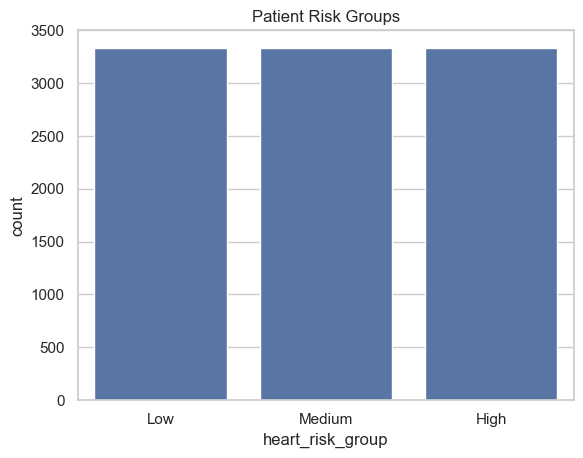

In [31]:
# STEP 6: Visualize the Scoring System

sns.histplot(weight_df["heart_risk_score"], kde=True, bins=30)
plt.title("Distribution of Heart Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Number of Patients")
# Save the chart
plt.savefig("Histogram Distribution of Heart Risk Scores", dpi=300, bbox_inches="tight")
plt.show()

sns.countplot(x="heart_risk_group", data=weight_df)
plt.title("Patient Risk Groups")
# Save the chart
plt.savefig("Column Distribution of Heart Risk Scores", dpi=300, bbox_inches="tight")
plt.show()

### Multiple Disease Prediction

Goal: I want to predict Heart and Diabetes disease in patients

### The common features for Diabetes prediction in the two(2) feature analysis include:

"Triglyceride Level", "Cholesterol Level", "Age", "BMI", "Homocysteine Level", "CRP Level", "Blood Pressure", "Fasting Blood Sugar"

### The common features for Heart prediction from feature analysis and domain knowledge include:

"Triglyceride Level", "Cholesterol Level", "Age", "BMI", "Homocysteine Level",  "Smoking", "High Blood Pressure", "Family Heart Disease", "Sleep Hours", "Stress Level_Medium"

In [32]:
# Create a common feature set.

shared_features = ["Triglyceride Level","Age","BMI","Cholesterol Level","Homocysteine Level",
                   "CRP Level","Blood Pressure","Fasting Blood Sugar","Smoking","High Blood Pressure",
                   "Family Heart Disease","Sleep Hours","Stress Level_Medium"
                  ]
x_common = X_clean[shared_features]

In [42]:
# Label y_heart for heart disease

y_heart = df["Heart Disease Status"]
y_diabetes = df["Diabetes"]

### Heart Disease Prediction

Kindly note that Tree-based models are not affected by scaling process. Instead LogisticRegression is affected by scaling.

### 1. Using the common features

In [34]:
# Train Heart using RandomForestClassifier.

# Scale and split
scaler2 = MinMaxScaler()
X_scaled_heart2 = scaler2.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_heart2, y_heart, test_size=0.2, random_state=42)

# Train heart disease model
heart_model3 = RandomForestClassifier(random_state=42)
heart_model3.fit(X_train, y_train)

# Predict
heart_pred3 = heart_model3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, heart_pred3) * 100)

Accuracy: 80.65


In [35]:
X_scaled_heart2

array([[0.80666667, 0.61290323, 0.31775562, ..., 1.        , 0.60550307,
        1.        ],
       [0.11      , 0.82258065, 0.32822239, ..., 1.        , 0.79065749,
        0.        ],
       [0.97666667, 0.4516129 , 0.53889912, ..., 0.        , 0.07331375,
        0.        ],
       ...,
       [0.49333333, 0.88709677, 0.40452063, ..., 0.        , 0.07270068,
        0.        ],
       [0.04333333, 0.08064516, 0.77116934, ..., 0.        , 0.75436933,
        0.        ],
       [0.07      , 0.32258065, 0.32319814, ..., 1.        , 0.2764949 ,
        1.        ]])

In [36]:
# Train Heart using LogisticRegression and scaling with StandardScaler

# Scale and split
scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled2, y_heart, test_size=0.2, random_state=42)

# Train heart disease model
heart_model = LogisticRegression(max_iter=1000)
heart_model.fit(X_train, y_train)

# Predict
heart_pred = heart_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, heart_pred) * 100)

Accuracy: 80.65


In [37]:
# Train Heart using LogisticRegression and scaling with MinMaxScaler

# Scale and split
scaler3 = MinMaxScaler()
X_scaled_heart3 = scaler3.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_heart3, y_heart, test_size=0.2, random_state=42)

# Train heart disease model
heart_model4 = LogisticRegression(max_iter=1000)
heart_model4.fit(X_train, y_train)

# Predict
heart_pred4 = heart_model4.predict(X_test)
print("Accuracy:", accuracy_score(y_test, heart_pred4) * 100)

Accuracy: 80.65


In [39]:
# Train Heart using XGBoostClassifier

# Scale and split
scaler_heart5 = MinMaxScaler()
X_scaled_heart5 = scaler_heart5.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_heart5, y_heart, test_size=0.2, random_state=42)

# Train heart disease model
heart_model5 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
heart_model5.fit(X_train, y_train)

# Predict
heart_pred5 = heart_model5.predict(X_test)
print("Accuracy:", accuracy_score(y_test, heart_pred5) * 100)

C:\Users\HOME\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:43:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 78.64999999999999


### 2. Using the Top 10 features

In [53]:
# Using only the top 10 features that I noted from the Feature Analysis and Domain knowledge
top10features_df = X_clean[["Smoking", "High Blood Pressure", "Family Heart Disease", "Age", "Triglyceride Level", "BMI", "Homocysteine Level", "Sleep Hours", "Cholesterol Level", "Stress Level_Medium"]]

# Features and target
top_X = top10features_df
y = y

# Scale and split
top10_scaler = MinMaxScaler()
top10_scaled = top10_scaler.fit_transform(top_X)

# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(top10_scaled, y, test_size=0.2, random_state=42)

# Convert back to DataFrame
top10features = ["Smoking", "High Blood Pressure", "Family Heart Disease", "Age", "Triglyceride Level", "BMI", "Homocysteine Level", "Sleep Hours", "Cholesterol Level", "Stress Level_Medium"]
X_train_df = pd.DataFrame(X_train, columns=top10features)

# Train the model
top_features_model = RandomForestClassifier(random_state=42)
top_features_model.fit(X_train_df, y_train)

# Evaluate the model
y_pred = top_features_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred) * 100)

Accuracy: 80.65


C:\Users\HOME\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [52]:
top10features_df

,Smoking,High Blood Pressure,Family Heart Disease,Age,Triglyceride Level,BMI,Homocysteine Level,Sleep Hours,Cholesterol Level,Stress Level_Medium
0,1,1,1,56.0,342.0,24.991591,12.387250,7.633228,155.0,1
1,0,0,1,69.0,133.0,25.221799,19.298875,8.744034,286.0,0
2,0,0,0,46.0,393.0,29.855447,11.230926,4.440440,216.0,0
3,1,1,1,32.0,293.0,24.130477,5.961958,5.249405,293.0,0
4,1,1,1,60.0,263.0,20.486289,8.153887,7.030971,242.0,0
...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,25.0,343.0,18.788791,19.132004,6.834954,243.0,0
9996,0,1,0,38.0,377.0,31.856801,9.715709,8.247784,154.0,0
9997,1,0,0,73.0,248.0,26.899911,9.492429,4.436762,201.0,0
9998,1,1,0,23.0,113.0,34.964026,11.873486,8.526329,299.0,0


### Diabetes Disease Prediction

In [43]:
# Train Diabetes using RandomForestClassifier and scaling with StandardScaler

# Scale and split
scaler_diabetes2 = StandardScaler()
X_scaled_diabetes2 = scaler_diabetes2.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_diabetes2, y_diabetes, test_size=0.2, random_state=42)

# Train heart disease model
diabetes_model2 = RandomForestClassifier(random_state=42)
diabetes_model2.fit(X_train, y_train)

# Predict
diabetes_pred2 = diabetes_model2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, diabetes_pred2) * 100)

Accuracy: 51.15


In [44]:
# Train Diabetes using RandomForestClassifier and scaling with MinMaxScaler

# Scale and split
scaler_diabetes3 = MinMaxScaler()
X_scaled_diabetes3 = scaler_diabetes3.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_diabetes3, y_diabetes, test_size=0.2, random_state=42)

# Train heart disease model
diabetes_model3 = RandomForestClassifier(random_state=42)
diabetes_model3.fit(X_train, y_train)

# Predict
diabetes_pred3 = diabetes_model3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, diabetes_pred3) * 100)

Accuracy: 50.7


In [45]:
# Train Diabetes using LogisticRegression and scaling with StandardScaler

# Scale and split
scaler_diabetes1 = StandardScaler()
X_scaled_diabetes1 = scaler_diabetes1.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_diabetes1, y_diabetes, test_size=0.2, random_state=42)

# Train heart disease model
diabetes_model1 = LogisticRegression(max_iter=1000)
diabetes_model1.fit(X_train, y_train)

# Predict
diabetes_pred1 = diabetes_model1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, diabetes_pred1) * 100)

Accuracy: 49.9


In [46]:
# Train Diabetes using LogisticRegression and scaling with MinMaxScaler

# Scale and split
scaler_diabetes4 = MinMaxScaler()
X_scaled_diabetes4 = scaler_diabetes4.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_diabetes4, y_diabetes, test_size=0.2, random_state=42)

# Train heart disease model
diabetes_model4 = LogisticRegression(random_state=42)
diabetes_model4.fit(X_train, y_train)

# Predict
diabetes_pred4 = diabetes_model4.predict(X_test)
print("Accuracy:", accuracy_score(y_test, diabetes_pred4) * 100)

Accuracy: 49.85


In [47]:
# Train Diabetes using XGBoostClassifier

# Scale and split
scaler_diabetes5 = MinMaxScaler()
X_scaled_diabetes5 = scaler_diabetes5.fit_transform(x_common)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_diabetes5, y_diabetes, test_size=0.2, random_state=42)

# Train heart disease model
diabetes_model5 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
diabetes_model5.fit(X_train, y_train)

# Predict
diabetes_pred5 = diabetes_model5.predict(X_test)
print("Accuracy:", accuracy_score(y_test, diabetes_pred5) * 100)

C:\Users\HOME\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 50.64999999999999


### There were several methods that I used above, and they produced several results as well:
1. RandomForestClassifier: Heart; 80.65%, Diabetes(StandardScaler); 51.15%, Diabetes(MinMaxScaler); 50.7%
2. LogisticRegression: Heart; 80.65%, Diabetes(StandardScaler); 49.9%, Diabetes(MinMaxScaler); 49.85%
3. XGBoostClassifier: Heart; 50.65%, Diabetes(StandardScaler); 50.65%, Diabetes(MinMaxScaler); 50.65%

### Based on the above results, the following is the best model, so I will save ONLY THE Heart RF model with 10 features.

* RandomForestClassifier: Heart; 80.65%.

In [54]:
# Saving the heart model
joblib.dump(top_features_model, "top_features_heart_model.pkl")

['top_features_heart_model.pkl']

In [ ]:
# Saving the scaler
joblib.dump(top10_scaler, "top10_scaler.pkl")